 Function definitions for creating the datasets

 First we need to create our datasets that are going to be used for training our models.

 In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library.
 We will use these operand signs together with the MNIST dataset to represent the digits.

In [ ]:
import matplotlib.pyplot as plt
import cv2

import numpy as np
import pandas as pd

import tensorflow.keras as keras # type: ignore
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed # type: ignore
from tensorflow.keras.layers import RepeatVector # type: ignore

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

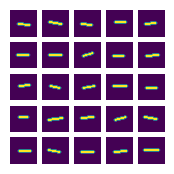

In [ ]:
from scipy.ndimage import rotate


np.random.seed(42)

# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images


def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())

In [ ]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:
    
    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=False)
                query_image = []

                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=False)
                result_image = []
                
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())
                    
                X_text.append(query_string)
                X_img.append(np.stack(query_image))

                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '

    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

 # Creating our data

 The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

   **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]
   **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

   **y_text**: strings containing answers of length 3: ['  2', '156']
   **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #6745

X_text: "33-72" = y_text: "-39"


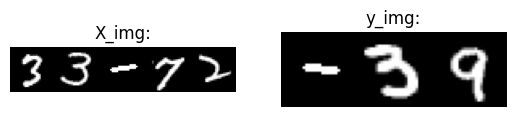

Query #2107

X_text: "10-53" = y_text: "-43"


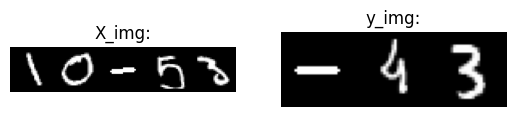

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)

## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
        
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(2):
    display_sample(np.random.randint(0, 10000, 1)[0])

 ## Helper functions



 The functions below will help with input/output of the data.

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs

# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    
    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


 ---

 ---



 ## III. Text to image RNN Model



 Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.



 The goal here is to use **X_text** as inputs and **y_img** as outputs.

(84000, 28, 28) (84000,)


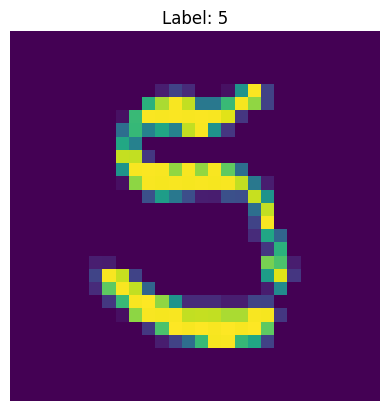

In [ ]:
# Your code

#MNIST CLASSIFICATION

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import pandas as pd

class DatasetPrep():
    def __init__(self, X_train, X_valid, y_train, y_valid, X_test, y_test, input_shape):
        self.input_shape = input_shape
        self.X_train = X_train
        self.X_valid = X_valid
        self.y_train = y_train
        self.y_valid = y_valid
        self.X_test = X_test
        self.y_test = y_test
        
def encode_out(labels):
    n = len(labels)
    characters = "1234567890- "
    char_map = dict(zip(characters, range(len(characters))))
    one_hot = np.zeros([n, len(characters)])
    
    for i, label in enumerate(labels):
        m = np.zeros([len(characters)])
        for j, char in enumerate(label):
            m[char_map[char]] = 1
        one_hot[i] = m
    return one_hot

def decode_out(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join(["1234567890- "[i] for i in pred])
    
    return predicted

def load_data(num_classes):
    img_rows, img_cols = 28, 28
    item_size = 7000
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    
    # Concatenate Train and Test
    X = np.concatenate((x_train, x_test), axis=0)
    Y = np.concatenate((y_train.astype(str), y_test.astype(str)), axis=0)
    
    # Add Minus Images
    X = np.concatenate((X, generate_images(item_size, '-')), axis=0)
    Y = np.concatenate((Y, np.full((item_size), '-')), axis=0)
    
    #Add Empty Images
    X = np.concatenate((X, np.zeros([item_size, img_rows, img_cols])), axis=0)
    Y = np.concatenate((Y, np.full((item_size), ' ')), axis=0)
    
    print(X.shape, Y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.50, random_state=42)
    
    if keras.backend.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
        X_valid = X_valid.reshape(X_valid.shape[0], 1, img_rows, img_cols)
        X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
        
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
        X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    
    plt.imshow(X_train[0])
    plt.title(f"Label: {y_train[0]}")
    unique_classes = np.unique(y_train)
    
    plt.axis('off')  # Remove the axes for better visualization
    plt.show()
   
    # Normalize as float32 values
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')
    X_test = X_test.astype('float32')
    
    # Normalize as normalize to 0-1
    X_train /= 255
    X_valid /= 255
    X_test /= 255
    
    # Convert to one hot encoding
    y_train = encode_out(y_train)
    y_valid = encode_out(y_valid)
    y_test = encode_out(y_test)
    input_shape = X_train.shape[1:]
  
    dataset_p = DatasetPrep(X_train, X_valid, y_train, y_valid, X_test, y_test, input_shape)
    
    return dataset_p

num_classes = 12
dataset_p = load_data(num_classes)

In [ ]:
def build_image_classifier(input_shape, kernel_initializer, activation):
    #regularizer
    kernel_regularizer = keras.regularizers.L2(0.01)
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation=activation, input_shape=input_shape, kernel_initializer=kernel_initializer, padding='same'))
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same'))

    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(64, (3, 3), activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer))
    
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(128, activation=activation,kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer))
    
    model.add(Dropout(0.2))    
    model.add(Dense(num_classes, activation='softmax'))

    # Create the optimizer with the tunable parameters
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=0.0001, weight_decay = 1e-4
        ),
        #optimizer = optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    model.summary()
    return model

In [ ]:
input_shape = dataset_p.input_shape
kernel_initializer = 'he_normal'
activation = 'relu'

image_classifier_model = build_image_classifier(input_shape, kernel_initializer, activation)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"mnist_classification_best.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=8,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = image_classifier_model.fit(
    dataset_p.X_train,
    dataset_p.y_train,
    validation_data=(dataset_p.X_valid, dataset_p.y_valid),
    batch_size=64,
    epochs=20,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)

2024-12-13 23:08:02.637429: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-13 23:08:06.771878: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-13 23:08:06.772216: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 9, 32)          0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                        

2024-12-13 23:08:08.570404: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-13 23:08:09.502603: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-13 23:08:12.593683: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-12-13 23:08:12.593733: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-12-13 23:08:12.593860: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-12-13 23:08:18.3633

1050/1050 [==============================] - 24s 4ms/step - loss: 2.5929 - accuracy: 0.9142 - val_loss: 1.4652 - val_accuracy: 0.9738 - lr: 1.0000e-04
Epoch 2/20
1050/1050 [==============================] - 3s 3ms/step - loss: 1.0371 - accuracy: 0.9725 - val_loss: 0.7007 - val_accuracy: 0.9806 - lr: 1.0000e-04
Epoch 3/20
1050/1050 [==============================] - 3s 3ms/step - loss: 0.5269 - accuracy: 0.9777 - val_loss: 0.3857 - val_accuracy: 0.9819 - lr: 1.0000e-04
Epoch 4/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.3096 - accuracy: 0.9818 - val_loss: 0.2437 - val_accuracy: 0.9838 - lr: 1.0000e-04
Epoch 5/20
1050/1050 [==============================] - 4s 3ms/step - loss: 0.2116 - accuracy: 0.9834 - val_loss: 0.1800 - val_accuracy: 0.9845 - lr: 1.0000e-04
Epoch 6/20
1050/1050 [==============================] - 3s 3ms/step - loss: 0.1646 - accuracy: 0.9843 - val_loss: 0.1459 - val_accuracy: 0.9836 - lr: 1.0000e-04
Epoch 7/20
1050/1050 [======================

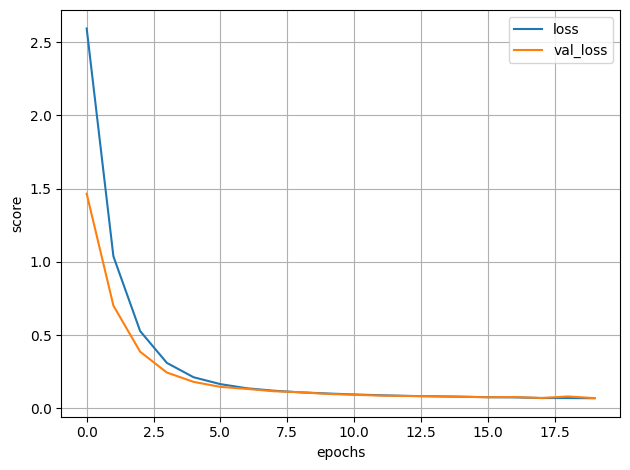

In [ ]:
import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('mnist_classification.csv')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
score3 = image_classifier_model.evaluate(dataset_p.X_test, dataset_p.y_test) 
print(score3)
# images = tf.unstack(y_img[100], axis=0)
# single_image = images[1]  # Shape: (28, 28, 1)
# plt.imshow(single_image, cmap='gray')

263/263 [==============================] - 1s 980us/step - loss: 0.0669 - accuracy: 0.9899
[0.0668945387005806, 0.9898809790611267]


In [ ]:
# TEXT TO IMAGE PREPARATION
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_img, test_size=0.20, random_state=42) 
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

_, _, y_train_text, y_test_text = train_test_split(X_text_onehot, y_text, test_size=0.20, random_state=42)
_, _, y_test_text, y_valid_text = train_test_split(_, y_test_text, test_size=0.5, random_state=42) 

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (ConvLSTM2D, TimeDistributed, GlobalMaxPooling2D, Conv2DTranspose,
                                     Dense, LSTM, RepeatVector, Dropout, BatchNormalization, Reshape,
                                     LayerNormalization, Flatten, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_text2img_model():

    text2img = tf.keras.Sequential()

    text2img.add(LSTM(256, input_shape=(None, len(unique_characters))))
    text2img.add(Dropout(0.1))
    text2img.add(RepeatVector(max_answer_length))

    # add reshape 
    text2img.add(LSTM(256, return_sequences=True))
    text2img.add(Dropout(0.1))
    
    # text2img.add(TimeDistributed(Dense( 28 * 28, activation='sigmoid', kernel_regularizer=l2(0.001))))
    
    # lets slowly increase the dense 
    text2img.add(TimeDistributed(Dense( 7 * 7 * 28, activation='sigmoid', kernel_regularizer=l2(0.001))))
    text2img.add(Reshape((3, 7, 7, 28)))

    #default_args=dict(kernel_size=(3,3),  padding='same', activation='relu')

    text2img.add(TimeDistributed(Conv2DTranspose(filters=7, kernel_size=(2, 2), strides=2, padding='same', 
                                                 activation='relu')))
    
    text2img.add(TimeDistributed(Conv2DTranspose(filters=7, kernel_size=(2, 2) ,strides=2, padding='same', 
                                                 activation = 'relu')))
    text2img.add(BatchNormalization())
    text2img.add(TimeDistributed(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid')))

    # Compile the model
    text2img.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    text2img.summary()
    #text2img.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    

    return text2img


def build_text2img_model_addl():

    text2img = tf.keras.Sequential()

    text2img.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))
    text2img.add(LSTM(256))
    text2img.add(Dropout(0.1))
    text2img.add(RepeatVector(max_answer_length))

    # add reshape 
    text2img.add(LSTM(256, return_sequences=True))
    text2img.add(Dropout(0.1))
    
    # text2img.add(TimeDistributed(Dense( 28 * 28, activation='sigmoid', kernel_regularizer=l2(0.001))))
    
    # lets slowly increase the dense 
    text2img.add(TimeDistributed(Dense( 7 * 7 * 28, activation='sigmoid', kernel_regularizer=l2(0.001))))
    text2img.add(Reshape((3, 7, 7, 28)))

    #default_args=dict(kernel_size=(3,3),  padding='same', activation='relu')

    text2img.add(TimeDistributed(Conv2DTranspose(filters=7, kernel_size=(2, 2), strides=2, padding='same', 
                                                 activation='relu')))
    
    text2img.add(TimeDistributed(Conv2DTranspose(filters=7, kernel_size=(2, 2) ,strides=2, padding='same', 
                                                 activation = 'relu')))
    text2img.add(BatchNormalization())
    text2img.add(TimeDistributed(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid')))

    # Compile the model
    text2img.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    text2img.summary()
    #text2img.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    

    return text2img

model = build_text2img_model()
model2 = build_text2img_model_addl()

2024-12-13 23:09:40.317518: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               276480    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 256)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 3, 256)            525312    
                                                                 
 dropout_3 (Dropout)         (None, 3, 256)            0         
                                                                 
 time_distributed (TimeDist  (None, 3, 1372)           352604    
 ributed)                                             

In [ ]:
# print(y_train)

# plt.imshow(np.hstack(y_train[200]), cmap='gray')  # Display the frame in grayscale
# plt.title(f"Y")
# plt.axis("off")
# plt.show()

In [ ]:
def run_model(model):
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
            f"text_to_image_best_previous.keras", save_best_only=True
        )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',  # metric to monitor
        patience=8,          # number of epochs to wait for improvement
        restore_best_weights=True  # restore the best weights after stopping
    )

    lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        batch_size=32,
        epochs=50,
        callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
    )

    model.save(f'submission1_text_to_image_previous.keras')

    from tensorflow.keras.models import load_model

    # Path to the saved model file
    model_path = 'submission1_text_to_image_previous.keras'

    # Load the model
    model = load_model(model_path)

    import pandas as pd
    data_history = pd.DataFrame(history.history)
    data_history.to_csv('text_to_image_history_previous.csv')
    plt.plot(data_history['loss'], label='loss')
    plt.plot(data_history['val_loss'], label='val_loss')
    plt.xlabel('epochs')
    plt.ylabel('score')
    plt.legend(loc="best")


    plt.grid(True)
    plt.tight_layout()
    plt.show()

    import pandas as pd
    from sklearn.metrics import accuracy_score

    input_data = X_test
    labels = y_test_text
    output_images = model.predict(input_data).reshape((input_data.shape[0] * 3, 28, 28))

    predicted_nhot = image_classifier_model.predict(output_images)
    predicted_images_values = []
    for i in range(input_data.shape[0]):
        predicted_images_values.append(decode_out(predicted_nhot[i*3:i*3+3]))


    print(len(predicted_images_values))

    print("Accuracy Score: ", accuracy_score(labels, predicted_images_values))

    flat_pred = [i for pred in predicted_images_values for i in pred]
    flat_label = [i for lab in labels for i in lab]
    print("Character Accuracy Score:", accuracy_score(flat_label, flat_pred))


    preds = predicted_images_values
    trues = labels
    # symbol by symbol
    wrong_positions = np.argwhere(np.array(preds)!=trues)
    # TODO visualize the differences perhaps scatterplot
    #find out what kind of mistakes your models make on the misclassified samples.
    wrong_data = X_test[wrong_positions]
    decoded_wrong_inputs = [list(map(decode_labels,data)) for data in wrong_data]

    # decoded_wrong_inputs = [[list(map(decode_labels,data)) for data in model_wrong_data] for model_wrong_data in wrong_data]
    wrong_outputs = np.array(preds)[wrong_positions]
    from collections import Counter
    counter = Counter([(true,pred) for true,pred in zip(flat_label,flat_pred)])

    x=[each[0] for each in counter.keys()]
    y=[each[1] for each in counter.keys()]
    z=[each for each in counter.values()]
    l = list(zip(x,y,z))
    l = sorted([(i,i,0) for i in unique_characters]) + l
    x,y,z = [i[0] for i in l],[i[1] for i in l],[i[2] for i in l]

    z = np.log10(z)
    plt.figure(figsize=(8,6))
    sc = plt.scatter(x, y, c=z, cmap='coolwarm_r', s=50, edgecolor='none')
    plt.colorbar(sc, label='Intensity')
    plt.title("Heated Scatter Plot (Color by Value)")
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")
    plt.show()

Epoch 1/50


2024-12-13 23:10:22.819379: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-13 23:10:25.847376: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-13 23:10:25.847817: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-13 23:10:25.848014: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-13 23:10:25.848245: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-13

500/500 [==============================] - 12s 7ms/step - loss: 0.0955 - accuracy: 0.8355 - val_loss: 0.0555 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 2/50
500/500 [==============================] - 3s 6ms/step - loss: 0.0520 - accuracy: 0.8614 - val_loss: 0.0504 - val_accuracy: 0.8671 - lr: 0.0010
Epoch 3/50
500/500 [==============================] - 3s 6ms/step - loss: 0.0498 - accuracy: 0.8617 - val_loss: 0.0485 - val_accuracy: 0.8686 - lr: 0.0010
Epoch 4/50
500/500 [==============================] - 3s 6ms/step - loss: 0.0484 - accuracy: 0.8615 - val_loss: 0.0500 - val_accuracy: 0.8501 - lr: 0.0010
Epoch 5/50
500/500 [==============================] - 3s 6ms/step - loss: 0.0480 - accuracy: 0.8612 - val_loss: 0.0475 - val_accuracy: 0.8619 - lr: 0.0010
Epoch 6/50
500/500 [==============================] - 2s 4ms/step - loss: 0.0477 - accuracy: 0.8610 - val_loss: 0.0475 - val_accuracy: 0.8556 - lr: 0.0010
Epoch 7/50
500/500 [==============================] - 1s 3ms/step - loss: 0.0476

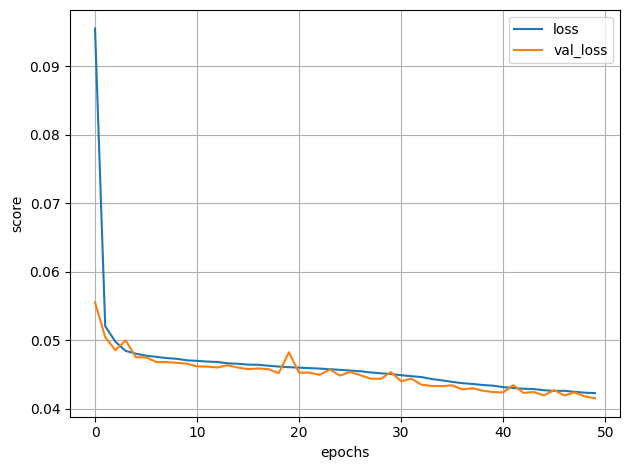

188/188 [==============================] - 0s 480us/step
2000
Accuracy Score:  0.6135
Character Accuracy Score: 0.8686666666666667


<ipython-input-19-8719ffc59c69>:91: RuntimeWarning: divide by zero encountered in log10
  z = np.log10(z)


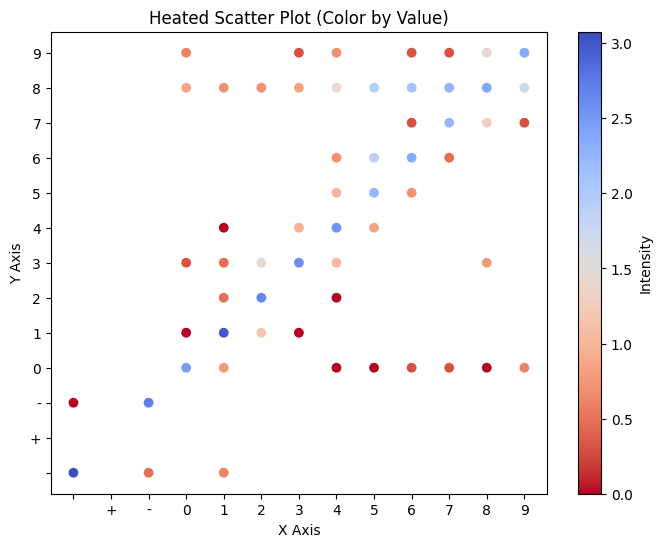

In [ ]:
run_model(model=model)

In [ ]:
def run_plotting():
    from tensorflow.keras.models import load_model

    # Path to the saved model file
    model_path = 'submission1_text_to_image_previous.keras'

    # Load the model
    model = load_model(model_path)

    import pandas as pd
    data_history = pd.DataFrame(history.history)
    data_history.to_csv('text_to_image_history_previous.csv')
    plt.plot(data_history['loss'], label='loss')
    plt.plot(data_history['val_loss'], label='val_loss')
    plt.xlabel('epochs')
    plt.ylabel('score')
    plt.legend(loc="best")


    plt.grid(True)
    plt.tight_layout()
    plt.show()

    import pandas as pd
    from sklearn.metrics import accuracy_score

    input_data = X_test
    labels = y_test_text
    output_images = model.predict(input_data).reshape((input_data.shape[0] * 3, 28, 28))

    predicted_nhot = image_classifier_model.predict(output_images)
    predicted_images_values = []
    for i in range(input_data.shape[0]):
        predicted_images_values.append(decode_out(predicted_nhot[i*3:i*3+3]))


    print(len(predicted_images_values))

    print("Accuracy Score: ", accuracy_score(labels, predicted_images_values))

    flat_pred = [i for pred in predicted_images_values for i in pred]
    flat_label = [i for lab in labels for i in lab]
    print("Character Accuracy Score:", accuracy_score(flat_label, flat_pred))


    preds = predicted_images_values
    trues = labels
    # symbol by symbol
    wrong_positions = np.argwhere(np.array(preds)!=trues)
    # TODO visualize the differences perhaps scatterplot
    #find out what kind of mistakes your models make on the misclassified samples.
    wrong_data = X_test[wrong_positions]
    decoded_wrong_inputs = [list(map(decode_labels,data)) for data in wrong_data]

    # decoded_wrong_inputs = [[list(map(decode_labels,data)) for data in model_wrong_data] for model_wrong_data in wrong_data]
    wrong_outputs = np.array(preds)[wrong_positions]
    from collections import Counter
    counter = Counter([(true,pred) for true,pred in zip(flat_label,flat_pred)])

    x=[each[0] for each in counter.keys()]
    y=[each[1] for each in counter.keys()]
    z=[each for each in counter.values()]
    l = list(zip(x,y,z))
    l = sorted([(i,i,0) for i in unique_characters]) + l
    x,y,z = [i[0] for i in l],[i[1] for i in l],[i[2] for i in l]

    # z = np.log10(z)
    # plt.figure(figsize=(8,6))
    # sc = plt.scatter(x, y, c=z, cmap='coolwarm_r', s=50, edgecolor='none')
    # plt.colorbar(sc, label='Intensity')
    # plt.title("Heated Scatter Plot (Color by Value)")
    # plt.xlabel("X Axis")
    # plt.ylabel("Y Axis")
    # plt.show()
    
    
    from sklearn.metrics import confusion_matrix
    from matplotlib.colors import LogNorm
    import seaborn as sns
    
    fig, ax = plt.subplots(1, 1, figsize=(10,8))
    cm = confusion_matrix(list(flat_label), list(flat_pred))
    
    g = sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax, norm=LogNorm(), cbar=False)
    g.set_xticklabels(['ws', 'neg'] + list('0123456789'))
    g.set_yticklabels(['ws', 'neg'] + list('0123456789'))
    ax.set_title('Confusion Matrix(in %)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.show()

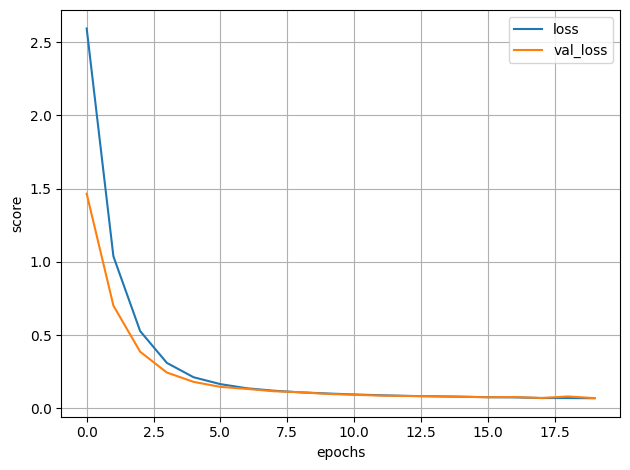

188/188 [==============================] - 0s 633us/step
2000
Accuracy Score:  0.6135
Character Accuracy Score: 0.8686666666666667


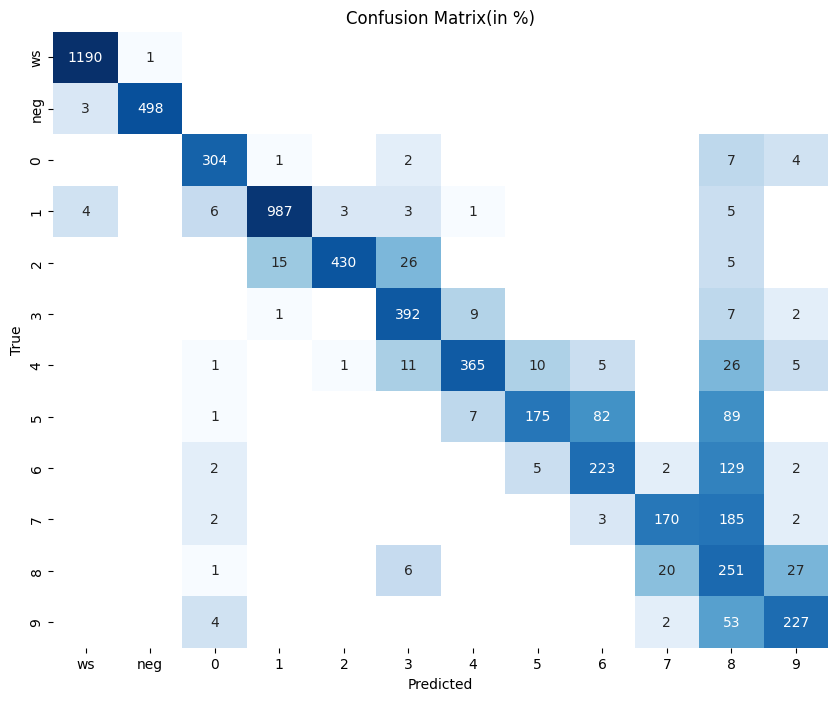

In [ ]:
run_plotting()

Epoch 1/50
500/500 [==============================] - 6s 8ms/step - loss: 0.1428 - accuracy: 0.7950 - val_loss: 0.1067 - val_accuracy: 0.8134 - lr: 0.0010
Epoch 2/50
500/500 [==============================] - 4s 8ms/step - loss: 0.0777 - accuracy: 0.8372 - val_loss: 0.0525 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 3/50
500/500 [==============================] - 4s 8ms/step - loss: 0.0517 - accuracy: 0.8627 - val_loss: 0.0505 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 4/50
500/500 [==============================] - 4s 8ms/step - loss: 0.0498 - accuracy: 0.8620 - val_loss: 0.0482 - val_accuracy: 0.8671 - lr: 0.0010
Epoch 5/50
500/500 [==============================] - 4s 8ms/step - loss: 0.0485 - accuracy: 0.8616 - val_loss: 0.0475 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 6/50
500/500 [==============================] - 4s 8ms/step - loss: 0.0480 - accuracy: 0.8613 - val_loss: 0.0474 - val_accuracy: 0.8616 - lr: 0.0010
Epoch 7/50
500/500 [==============================] - 4s 8ms/step - lo

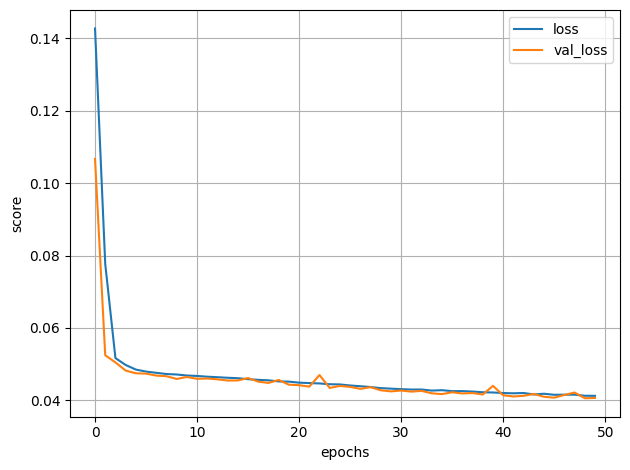

188/188 [==============================] - 0s 455us/step
2000
Accuracy Score:  0.8595
Character Accuracy Score: 0.952


<ipython-input-19-8719ffc59c69>:91: RuntimeWarning: divide by zero encountered in log10
  z = np.log10(z)


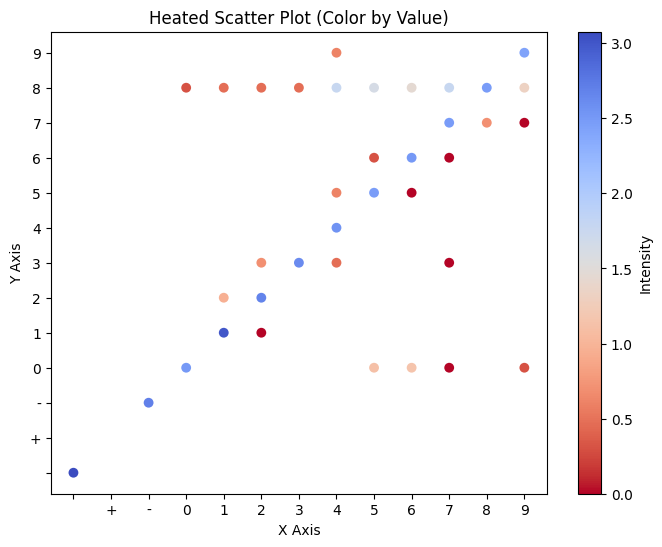

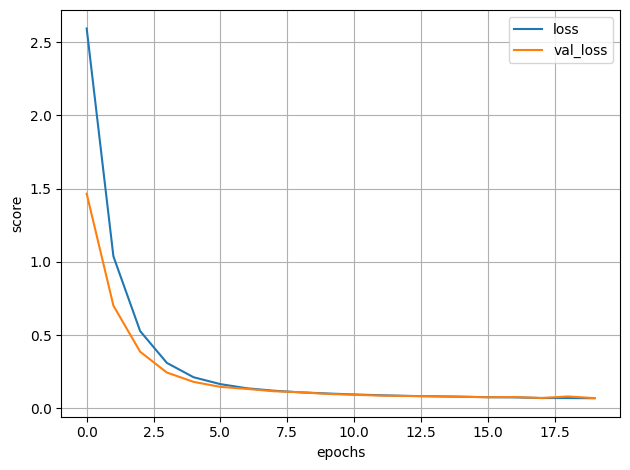

188/188 [==============================] - 0s 659us/step
2000
Accuracy Score:  0.8595
Character Accuracy Score: 0.952


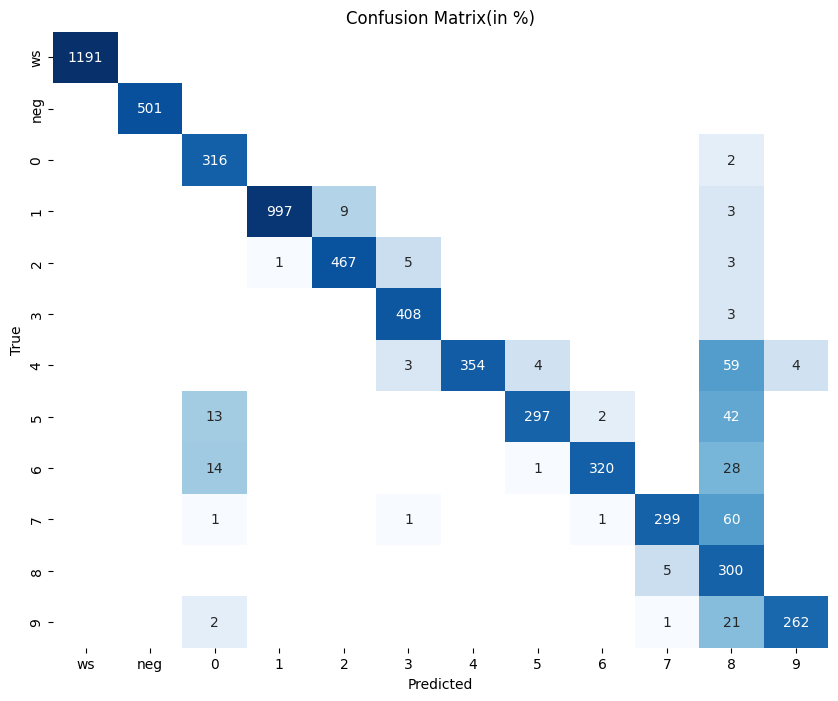

In [ ]:
run_model(model=model2)
run_plotting()